In [2]:
# Import packages
import cv2
import math
import skimage.io

# Import some functions to the global namespace for convenience
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import *
from scipy.stats import *
from skimage.filters import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *
import skimage.util
from mpl_toolkits import mplot3d

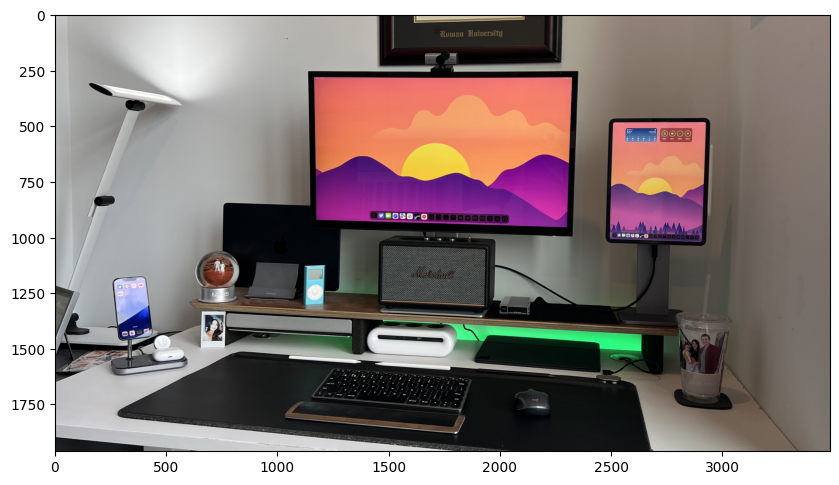

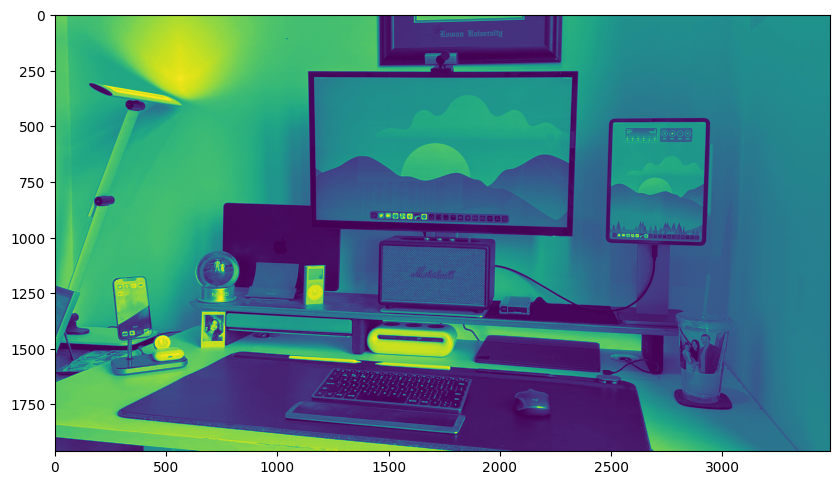

In [3]:
url = "http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.07"
url = "https://9to5mac.com/wp-content/uploads/sites/6/2023/01/IMG_4930-2-min.jpg"
img = skimage.io.imread(url, plugin = 'pil')
#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(10,6))
plt.imshow (img)
plt.show ()

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,6))
plt.imshow (img)
plt.show ()

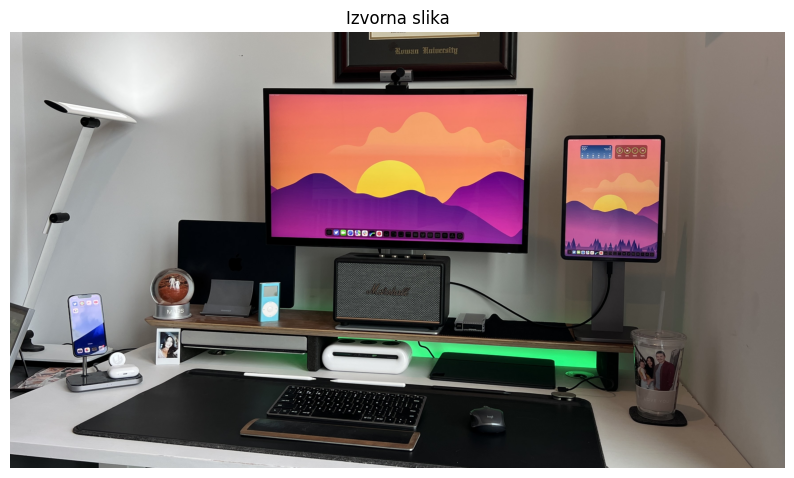

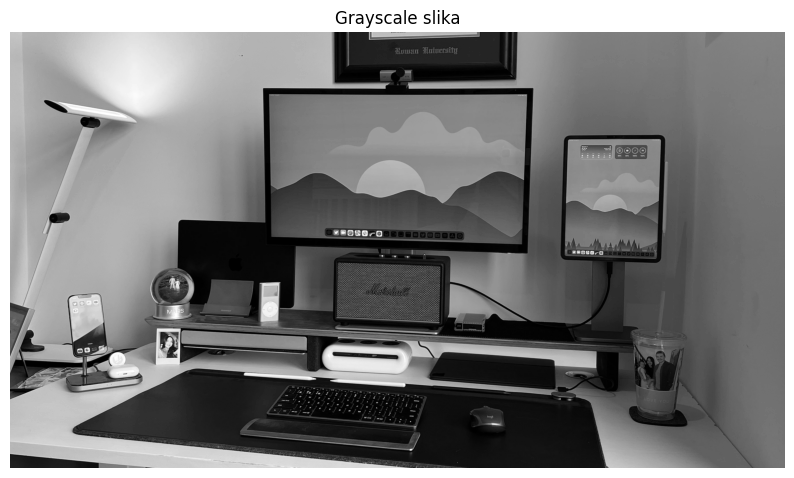

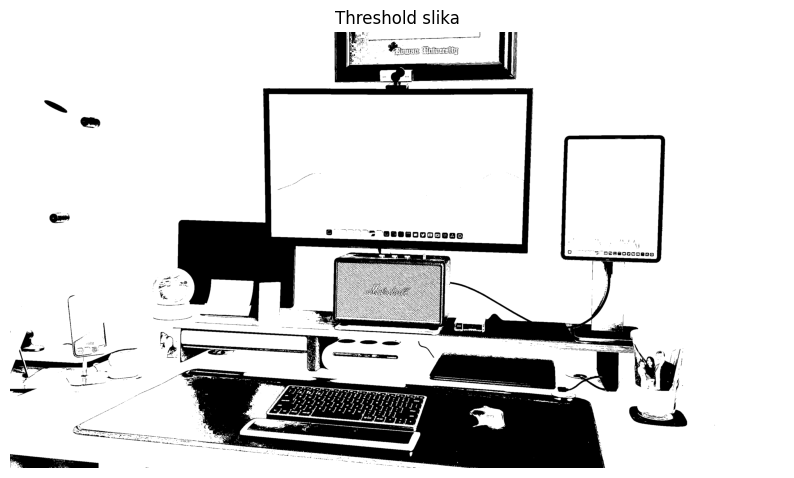

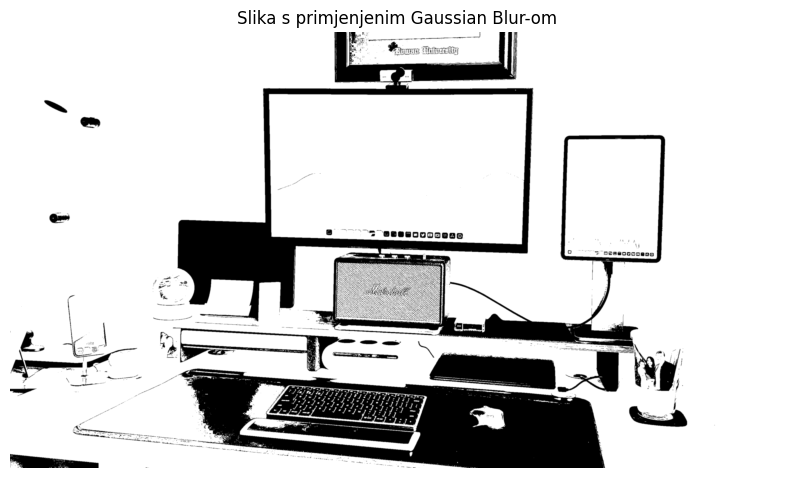

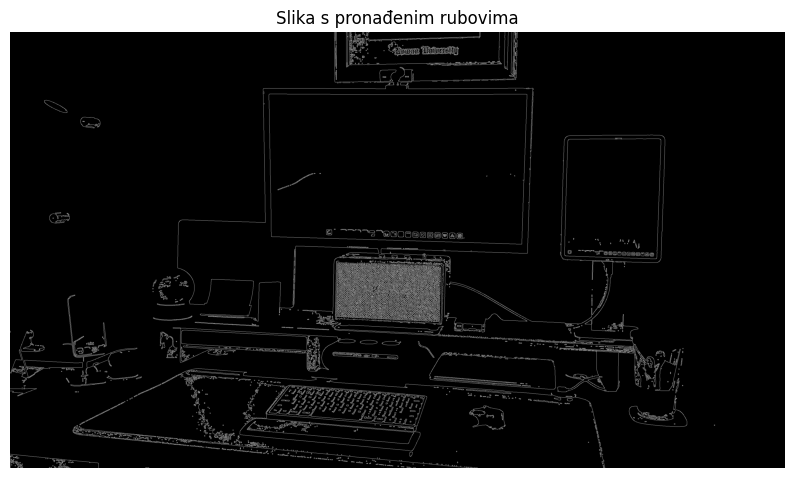

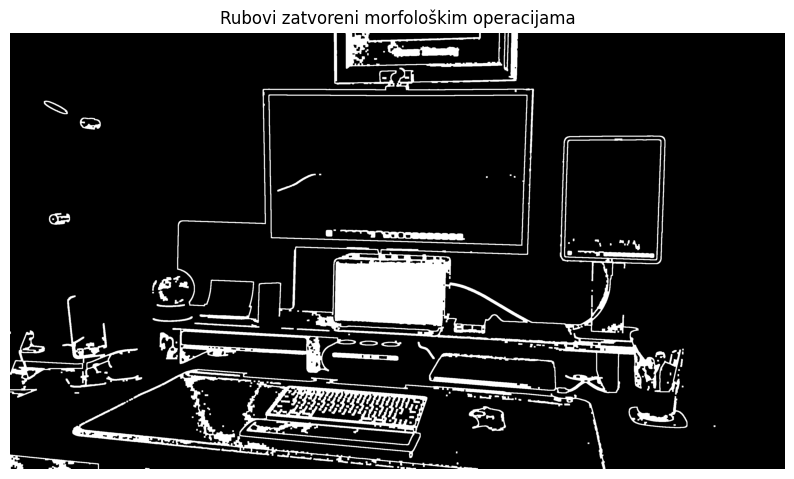

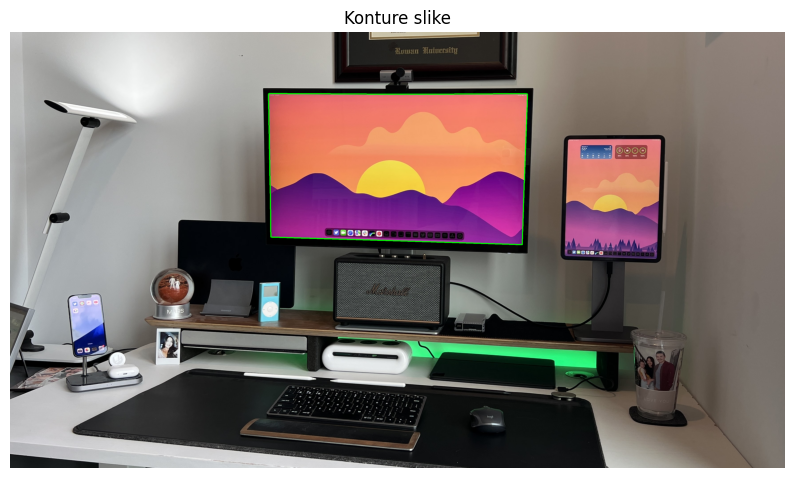

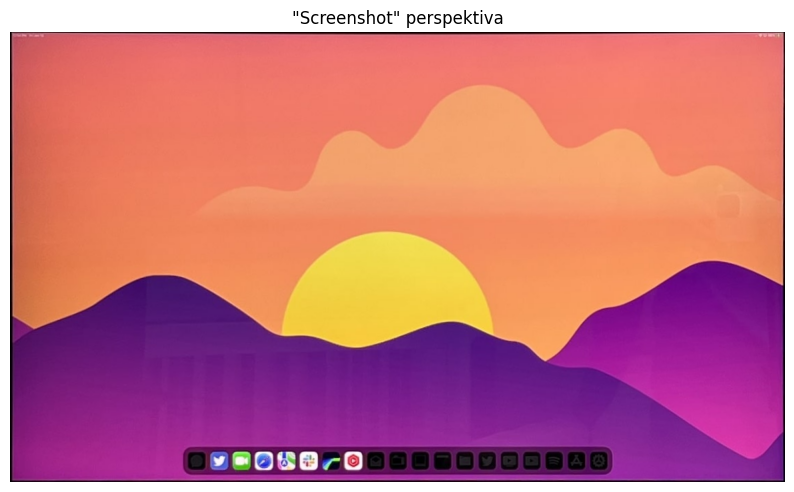

In [6]:


def show_image(image, title="Slika", cmap_type='gray'):
    plt.figure(figsize=(10, 6))
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

url = "https://9to5mac.com/wp-content/uploads/sites/6/2023/01/IMG_4930-2-min.jpg"
img = skimage.io.imread(url, plugin='pil')

# Izvorna slika
show_image(img, title='Izvorna slika', cmap_type=None)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(img_gray, title='Grayscale slika')

# Thresholdana slika
_, thresh = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY)
show_image(thresh, title='Threshold slika')

# Gaussian Blur - koristan prije pronalaska rubova zbog smanjenja šuma
kernel_size = 5
blur_gray = cv2.GaussianBlur(thresh, (kernel_size, kernel_size), 0)
show_image(blur_gray, title='Slika s primjenjenim Gaussian Blur-om')

# Pronalaženje rubova
edges = cv2.Canny(blur_gray, 10, 200)
show_image(edges, title='Slika s pronađenim rubovima')

# Morfološke operacije za zatvaranje rubova
kernel = np.ones((5, 5), np.uint8)
edges_dilated = cv2.dilate(edges, kernel, iterations=1)
edges_closed = cv2.morphologyEx(edges_dilated, cv2.MORPH_CLOSE, kernel)
show_image(edges_closed, title='Rubovi zatvoreni morfološkim operacijama')

# Pronalaženje kontura
contours, _ = cv2.findContours(edges_closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Pronalaženje najveće konture
screen_contour = max(contours, key=cv2.contourArea)

# Crtanje kontura
img_contour = img.copy()
cv2.drawContours(img_contour, [screen_contour], -1, (0, 255, 0), 3)
show_image(img_contour, title='Konture slike', cmap_type=None)

# Aproksimira konturu na kvadratni oblik
epsilon = 0.1 * cv2.arcLength(screen_contour, True)
approx = cv2.approxPolyDP(screen_contour, epsilon, True)

# Ako imamo 4 točke, pretpostavljamo da je to ekran
if len(approx) == 4:
    
    # Rasporedimo točke u pravilnom slijedu
    pts = approx.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # Dobivanje dimenzija ekrana radi mijenjanja perspektive
    (topLeft, topRight, bottomRight, bottomLeft) = rect
    widthA = np.linalg.norm(bottomRight - bottomLeft)
    widthB = np.linalg.norm(topRight - topLeft)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(topRight - bottomRight)
    heightB = np.linalg.norm(topLeft - bottomLeft)
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Transformacija perspektive
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    show_image(warped, title='"Screenshot" perspektiva', cmap_type=None)
else:
    print("Could not find a screen contour with 4 points.")